# Damage Classification

*Author: Ian Viotti, 2022*

*Gemec - Unifei*

The scope of this program is to fit a model to classify wich kind of damage the plate is subjected by reading the first 5 natural frequencies, obtained by FEA.

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Colect data

The data is colected by reading a .csv file and inputing it into a Pandas DataFrame

Auxiliary function to sort damages in order

In [2]:
def dam_num(file_name):
    try:
        dam_num = int(file_name.split('_')[0])
    except:
        dam_num = np.inf
    return dam_num

Read skin and core damage variables

In [3]:
skin_var = pd.read_csv('skin_damage_variables.csv')
core_var = pd.read_csv('core_damage_variables.csv')

### Get skin damage data

In [4]:
os.chdir(os.path.join(os.getcwd(), 'skin_damage'))
skin_files = os.listdir()

Get all natural frequencies file name

In [5]:
skin_files.sort(key = dam_num)

skin_df = pd.DataFrame(columns = [0, 1, 2, 3, 4])

for file in skin_files:
    if 'frequencias_naturais' in file:
        freq_file = pd.read_csv(file ,sep='\s+', skiprows=[1,2,3,4],
                       names=['SET','FREQ [Hz]', 'LOAD STEP', 'SUBSTEP', 'CUMULATIVE'] )
        freq_file = freq_file.drop(columns = ['LOAD STEP', 'SUBSTEP', 'CUMULATIVE', 'SET'])
        
        # Get damage number
        dam_number = file.split('_')[0] 
        
        # Rename column to damage number       
        freq_file = freq_file.rename(columns = {'FREQ [Hz]': f'Skin damage {dam_number}'}) 
        # Transpose df
        freq_file = freq_file.T 
        
        # Check if damage is in ply_num 1 (inter) or other ply (skin)
        if skin_var['n'][int(dam_number) - 1] == 1: 
            freq_file.insert(5, 'Type', 'Interface')
        else:
            freq_file.insert(5, 'Type', 'Skin')
            
        # Exclude modes 5, 6, 7, 8, 9 
        freq_file = freq_file.drop(columns = [5, 6, 7, 8, 9]) 
        
        # Concatenate this model freqs to core_df
        skin_df = pd.concat([skin_df, freq_file], axis = 0) 

In [6]:
skin_df

,0,1,2,3,4,Type
Skin damage 1,209.86,351.03,836.06,1044.9,1180.1,Interface
Skin damage 2,210.07,350.82,834.98,1044.7,1179.3,Skin
Skin damage 3,210.25,351.16,835.75,1044.9,1179.7,Skin
Skin damage 4,209.88,349.97,832.98,1043.8,1175.6,Skin
Skin damage 5,210.28,351.01,835.82,1043.8,1177.7,Interface
...,...,...,...,...,...,...
Skin damage 996,210.26,351.18,835.88,1044.8,1179.8,Interface
Skin damage 997,210.27,350.7,835.46,1042.3,1174.3,Skin
Skin damage 998,209.57,350.54,835.33,1044.8,1179.2,Skin
Skin damage 999,210.26,350.83,835.57,1043.2,1176.5,Interface


### Get core damage data

In [7]:
os.chdir('../')
os.chdir(os.path.join(os.getcwd(), 'core_damage'))
core_files = os.listdir()

In [8]:
core_files.sort(key = dam_num)

core_df = pd.DataFrame(columns = [0, 1, 2, 3, 4])

for file in core_files:
    if 'frequencias_naturais' in file:
        freq_file = pd.read_csv(file ,sep='\s+', skiprows=[1,2,3,4],
                       names=['SET','FREQ [Hz]', 'LOAD STEP', 'SUBSTEP', 'CUMULATIVE'] )
        freq_file = freq_file.drop(columns = ['LOAD STEP', 'SUBSTEP', 'CUMULATIVE', 'SET'])
        
        dam_number = file.split('_')[0] # Get damage number
                
        freq_file = freq_file.rename(columns = {'FREQ [Hz]': f'Core damage {dam_number}'}) # Rename column to damage number
        freq_file = freq_file.T # Transpose df
        
        freq_file.insert(5, 'Type', 'Core')
       
        freq_file = freq_file.drop(columns = [5, 6, 7, 8, 9]) # Exclude these modes
                
        core_df = pd.concat([core_df, freq_file], axis = 0) # Concatenate this model freqs to core_df

Put the values of all three kind of damage in the same dataframe

In [9]:
dam_df = pd.concat([core_df, skin_df])

Randomize values

In [10]:
dam_df = dam_df.sample(frac=1)
dam_df

,0,1,2,3,4,Type
Core damage 897,209.68,349.07,826.9,1034.1,1167.8,Core
Core damage 787,209.57,349.02,827.62,1034.4,1170.1,Core
Core damage 555,209.71,349.1,826.76,1033.9,1167.1,Core
Core damage 828,209.43,348.38,825.48,1031.9,1167.4,Core
Core damage 860,209.45,348.55,826.57,1033.3,1167.3,Core
...,...,...,...,...,...,...
Core damage 613,209.61,349.04,827.56,1034.2,1169.4,Core
Skin damage 452,210.29,351.2,836.07,1044.3,1179.0,Skin
Skin damage 335,209.93,350.51,834.46,1044.6,1178.4,Skin
Core damage 669,209.59,349.04,827.44,1034.1,1170.3,Core


## Visualize the Data 

The Seaborn function `pairplot()` is really useful to visualize the correlation between the natural frequencies for each kind of damage.

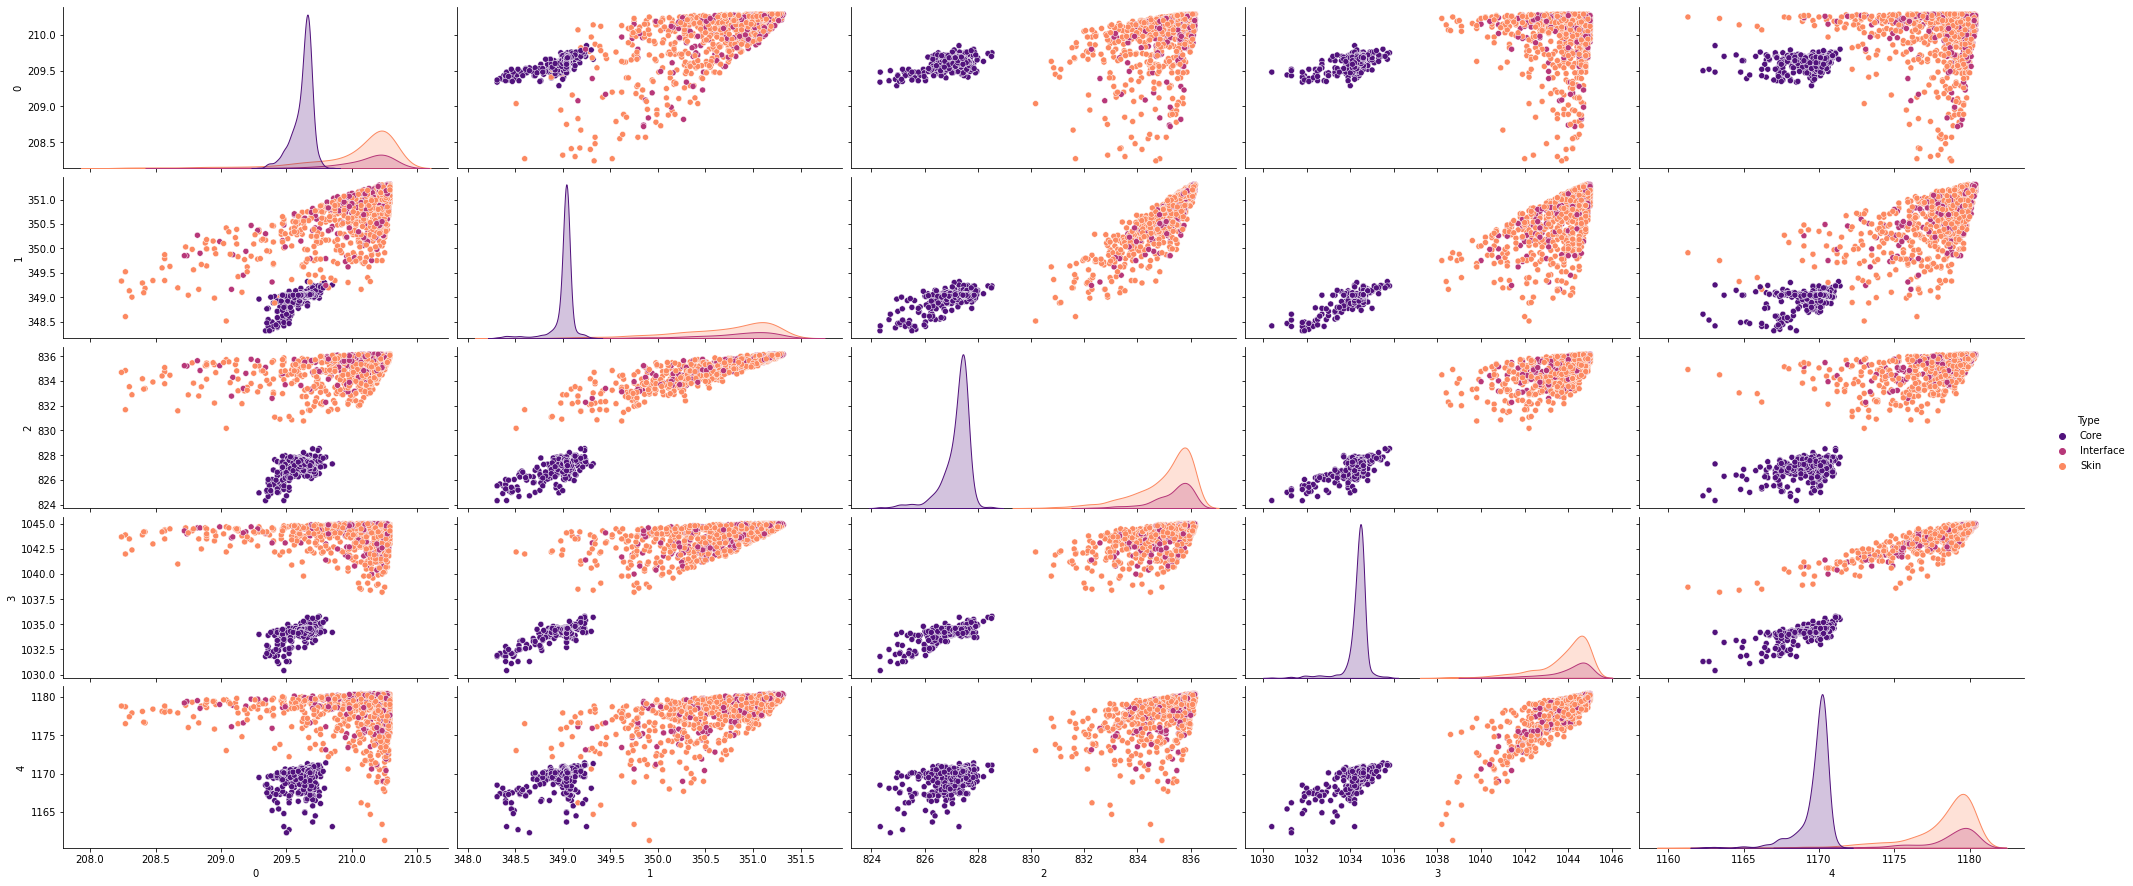

In [11]:
pair_grid = sns.pairplot(data = dam_df, hue = 'Type', aspect = 2.3, palette="magma")

Analysing the scatter plots, is really easy to see how the core damage distinguishes from the others. In the other hand, the difference between skin and interface damage is imperceptible.

## Preprocess the data

Isolating the data from the target values

In [12]:
type_df = dam_df['Type']
freq_df = dam_df[[0, 1, 2, 3, 4]]

### Standarization

Some models can only be trained by standarized data. This means that each column should have a **mean value of 0** and **deviation of 1**.

In [13]:
from sklearn import preprocessing
std = preprocessing.StandardScaler()
freq_scaled = std.fit_transform(freq_df)

### Separate the data for testing and training

The Current ratio is 1400 (76,3%) to train and 434 (23,6%) to test.

In [14]:
freq_train, freq_test, type_train, type_test = freq_scaled[:1400], freq_scaled[1400:], type_df[:1400], type_df[1400:]

## Classification

### Suport Vector Machine Classifier

Predicting using Suport Vector Machine Classifier.

A Support Vector Machine (SVM) is an algorithm that tries to
fit a line (or plane or hyperplane) between the different classes
that maximizes the distance from the line to the points of the
classes. In this way it tries to find a robust separation between
the classes. The support vectors are the points of the edge of the
dividing hyperplane.

In [15]:
from sklearn.svm import SVC

svm_clf = SVC(C = 1, class_weight = 'balanced', gamma = 'scale', probability = True)
svm_clf.fit(freq_train, type_train)
svm_clf.score(freq_test, type_test)

0.6912442396313364

Probability predicting (soft-classification)

In [16]:
svm_clf.predict_proba(freq_test[4].reshape(1, -1))

array([[0.00134194, 0.29402744, 0.70463062]])

Binary predicting (hard-classification)

In [17]:
svm_clf.predict(freq_test[4].reshape(1, -1))

array(['Interface'], dtype=object)

In [18]:
svm_clf

SVC(C=1, class_weight='balanced', probability=True)

#### Error Analysis

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

type_train_pred = cross_val_predict(svm_clf, freq_train, type_train)
conf_mx = confusion_matrix(type_train, type_train_pred, normalize = 'all')
conf_mx

array([[0.46642857, 0.        , 0.        ],
       [0.        , 0.105     , 0.02857143],
       [0.        , 0.28214286, 0.11785714]])

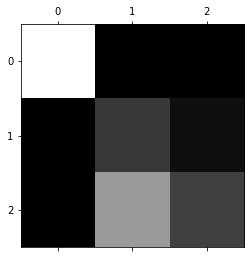

In [20]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

### Classification plot

In [21]:
prediction = []
for i in freq_test:
    prediction_i = svm_clf.predict(i.reshape(1, -1))
    prediction.append(prediction_i[0])

In [22]:
freq_tests_df = pd.DataFrame(freq_test)
prediction_series = pd.Series(prediction)

test_df = freq_tests_df.assign(pred=prediction_series.values, true = type_test.values)

conditions = [
    (test_df['pred'] != test_df['true']),
    (test_df['pred'] == test_df['true']),]
choices = ['Wrong', 'Right']

test_df['Prediction'] = np.select(conditions, choices)

test_df

,0,1,2,3,4,pred,true,Prediction
0,0.438704,1.207098,1.115207,1.132617,1.228619,Interface,Skin,Wrong
1,0.702838,1.078525,0.971239,1.111966,1.100092,Interface,Skin,Wrong
2,1.319152,1.335672,1.142511,0.967412,0.821618,Interface,Skin,Wrong
3,0.291962,0.789235,0.832235,1.091316,0.950145,Interface,Skin,Wrong
4,0.996321,1.014238,0.802448,0.822858,1.100092,Interface,Skin,Wrong
...,...,...,...,...,...,...,...,...
429,-0.676530,-0.957219,-0.977297,-1.097644,-1.063441,Core,Core,Right
430,1.319152,1.357101,1.135065,0.988063,0.992987,Interface,Skin,Wrong
431,0.262614,0.617804,0.735429,1.050014,0.864460,Interface,Skin,Wrong
432,-0.735227,-0.957219,-1.007083,-1.118294,-0.870650,Core,Core,Right


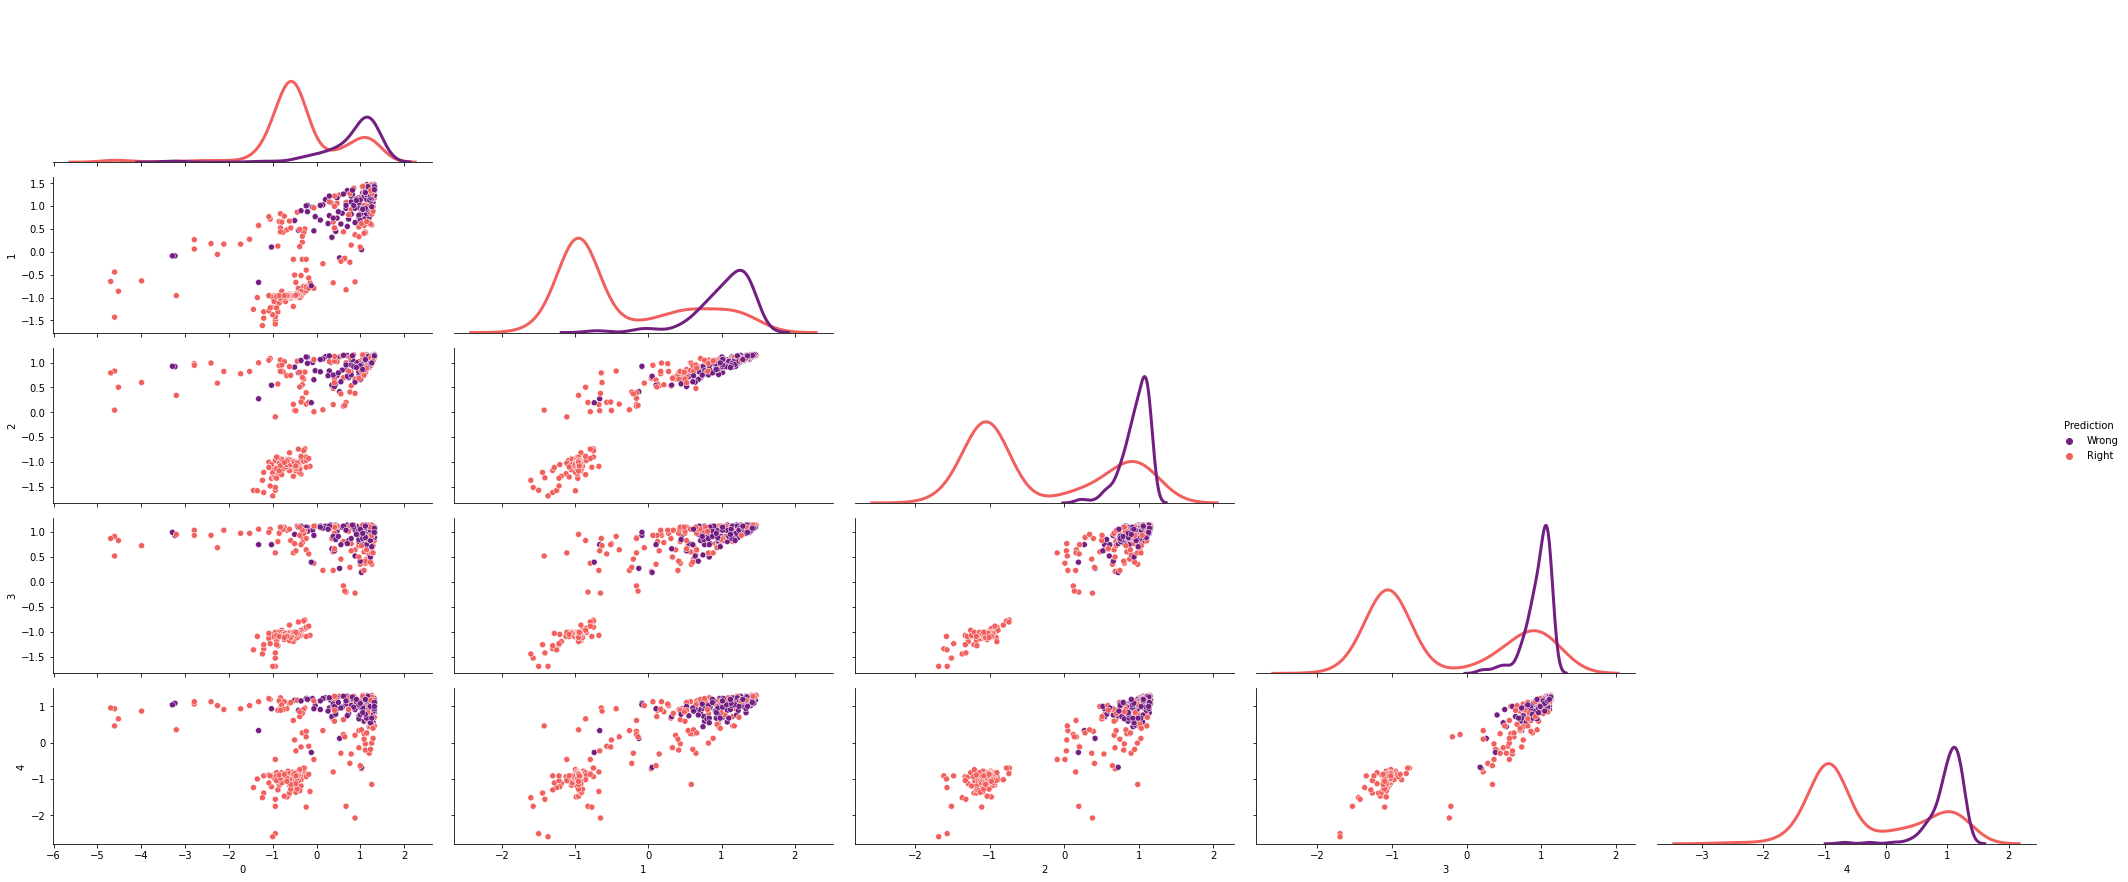

In [23]:
g = sns.PairGrid(test_df, corner = True, hue = 'Prediction', aspect = 2.3, palette="magma")
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.add_legend()
plt.show()

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(freq_train, type_train)

RandomForestClassifier(class_weight='balanced')

In [25]:
rf.score(freq_test, type_test)

0.8525345622119815

#### Error Analysis

In [26]:
type_train_pred_rf = cross_val_predict(rf, freq_train, type_train)
conf_mx_rf = confusion_matrix(type_train, type_train_pred_rf, normalize = 'all')
conf_mx_rf

array([[0.46642857, 0.        , 0.        ],
       [0.        , 0.02642857, 0.10714286],
       [0.        , 0.04      , 0.36      ]])

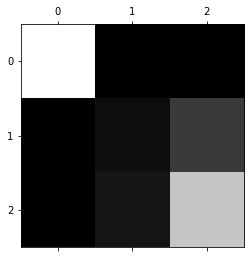

In [27]:
plt.matshow(conf_mx_rf, cmap=plt.cm.gray)